In [65]:
import pandas as pd
from sklearn.metrics import roc_auc_score, auc,roc_curve
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from category_encoders import *
#i=1

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [5]:
test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,36306,Male,80.0,0,0,Yes,Private,Urban,83.84,21.1,formerly smoked
1,61829,Female,74.0,0,1,Yes,Self-employed,Rural,179.50,26.0,formerly smoked
2,14152,Female,14.0,0,0,No,children,Rural,95.16,21.2,NaN
3,12997,Male,28.0,0,0,No,Private,Urban,94.76,23.4,NaN
4,40801,Female,63.0,0,0,Yes,Govt_job,Rural,83.57,27.6,never smoked


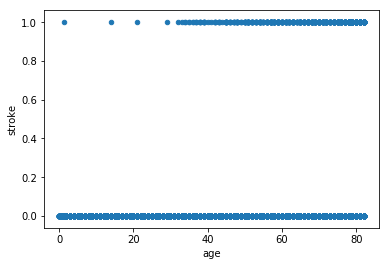

In [12]:
train.plot(x='age', y='stroke', kind ='scatter')

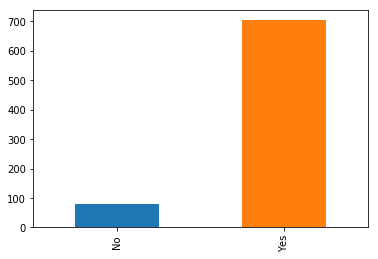

In [13]:
train[train['stroke']==1]['ever_married'].value_counts().sort_index().head(100).plot.bar()

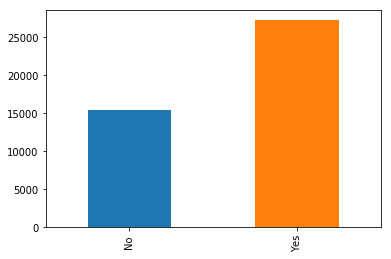

In [14]:
train[train['stroke']==0]['ever_married'].value_counts().sort_index().head(100).plot.bar()

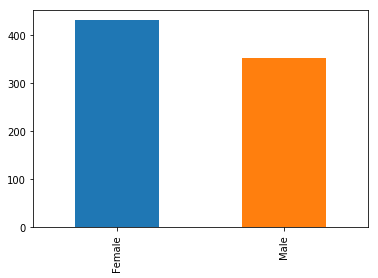

In [15]:
train[train['stroke']==1]['gender'].value_counts().sort_index().head(100).plot.bar()

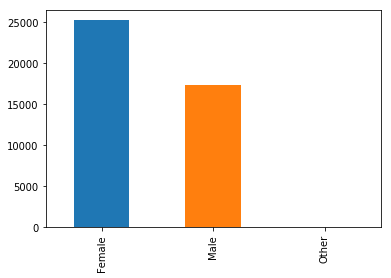

In [16]:
train[train['stroke']==0]['gender'].value_counts().sort_index().head(100).plot.bar()

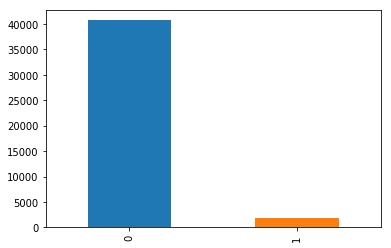

In [18]:
train[train['stroke']==0]['heart_disease'].value_counts().sort_index().head(100).plot.bar()

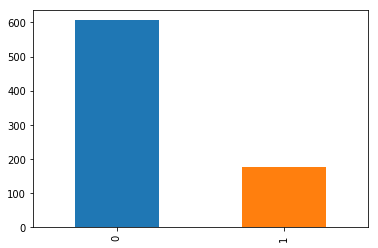

In [19]:
train[train['stroke']==1]['heart_disease'].value_counts().sort_index().head(100).plot.bar()

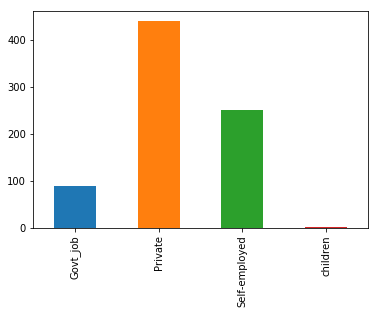

In [20]:
train[train['stroke']==1]['work_type'].value_counts().sort_index().head(100).plot.bar()

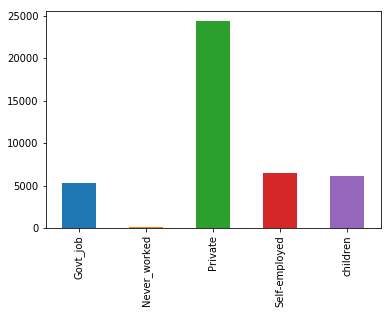

In [21]:
train[train['stroke']==0]['work_type'].value_counts().sort_index().head(100).plot.bar()

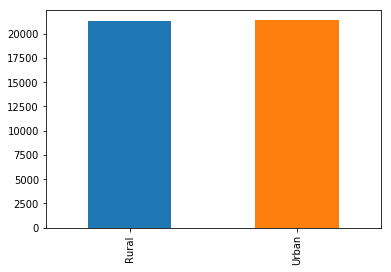

In [23]:
train[train['stroke']==0]['Residence_type'].value_counts().sort_index().head(100).plot.bar()

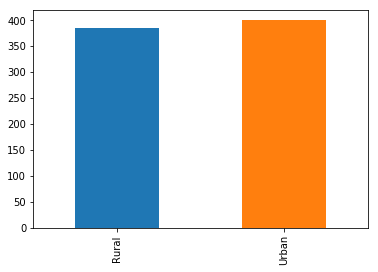

In [24]:
train[train['stroke']==1]['Residence_type'].value_counts().sort_index().head(100).plot.bar()

/Users/sohom.ghosh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a24c47f98>,
      dtype=object)

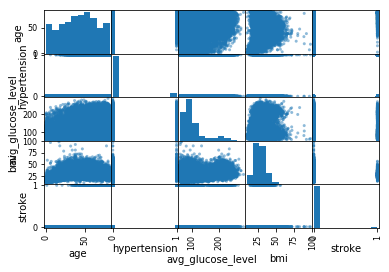

In [25]:
pd.scatter_matrix(train[['age','hypertension','avg_glucose_level','bmi','stroke']])

/Users/sohom.ghosh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a249f16d8>,
      dtype=object)

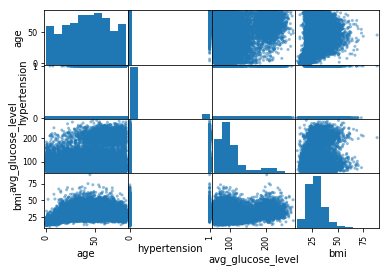

In [26]:
pd.scatter_matrix(test[['age','hypertension','avg_glucose_level','bmi']])

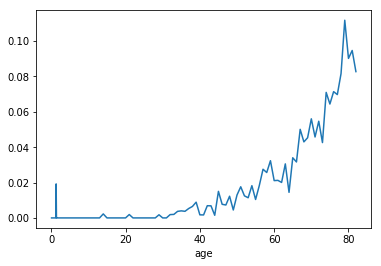

In [29]:
train.groupby('age')['stroke'].mean().plot()

In [40]:
age_gender_stroke = train.groupby(['age','gender'], as_index = False)['stroke'].mean()

In [41]:
age_gender_stroke.head()

,age,gender,stroke
0,0.08,Female,0.0
1,0.08,Male,0.0
2,0.16,Female,0.0
3,0.16,Male,0.0
4,0.24,Female,0.0


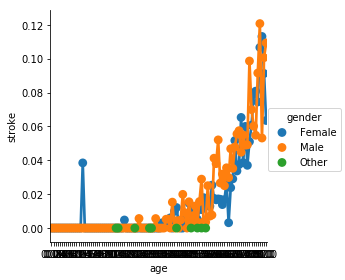

In [42]:
sns.factorplot(x='age', y='stroke', hue='gender', data=age_gender_stroke, fit_reg=False)
plt.show()

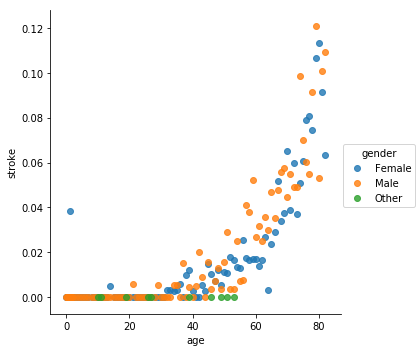

In [43]:
sns.lmplot(x='age', y='stroke', hue='gender', data=age_gender_stroke.dropna(), fit_reg=False)
plt.show()

In [31]:
train['hypertension'].value_counts()

0    39339
1     4061
Name: hypertension, dtype: int64

In [64]:
train_test = train.append(test)

# statmodels VIF

In [60]:
#variance_inflation_factor(exog, exog_idx)
#One recommendation is that if VIF is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this
df = train[['age','avg_glucose_level','bmi']].dropna()
pd.Series([variance_inflation_factor(df.values, i) for i in range(df.shape[1])], index=df.columns)

age                  5.270948
avg_glucose_level    6.297031
bmi                  8.360918
dtype: float64

# target encoding

In [79]:
X = train.iloc[:,train.columns != 'stroke']
y = train['stroke']
enc = BinaryEncoder(cols=['hypertension','heart_disease','gender','ever_married','work_type','Residence_type','smoking_status']).fit(X, y)
numeric_dataset_train = enc.transform(X)
numeric_dataset_test = enc.transform(test)
train_test_use = numeric_dataset_train.append(numeric_dataset_test) #if you want to use target encoding, uncomment this
train_test_use['stroke'] = list(train['stroke'].values) + [np.nan for i in range(len(test))]

# OR

# One hot encoding

In [30]:
train_test_use = pd.concat([train_test[['age','hypertension','heart_disease','avg_glucose_level','bmi','stroke']],pd.get_dummies(train_test[['gender','ever_married','work_type','Residence_type','smoking_status']])], axis=1)

# Modeling

In [102]:
X_train_all=train_test_use[0:len(train.index)]
X_test=train_test_use[len(train.index):len(train_test_use.index)]

X_train_all.columns = [str(i) for i in X_train_all.columns]
X_test.columns = [str(i) for i in X_test.columns]
features=list(X_train_all.columns)
features.remove('stroke')
X_train=X_train_all.sample(frac=0.80, replace=False)
X_valid=pd.concat([X_train_all, X_train]).drop_duplicates(keep=False)

dtrain = xgb.DMatrix(X_train[features],X_train['stroke'] , missing=np.nan)
dvalid = xgb.DMatrix(X_valid[features],missing=np.nan)
dtest = xgb.DMatrix(X_test[features], missing=np.nan)


In [103]:
nrounds = 35
watchlist = [(dtrain, 'train')]
params = {"objective": "binary:logistic","booster": "gbtree", "nthread": 4, "silent": 1,
                "eta": 0.087, "gamma":0.008, "max_depth": 6, "max_delta_step":0, "subsample": 0.9, "colsample_bytree": 0.7,
                "min_child_weight": 1, "sketch_eps":.02, "seed": 2016, "tree_method": "exact", "normalize_type":"tree", "eval_metric":"auc"}
bst = xgb.train(params, dtrain, num_boost_round=nrounds, evals=watchlist, verbose_eval=200)

[0]	train-auc:0.820633
[34]	train-auc:0.903246


In [104]:
valid_preds = bst.predict(dvalid)
test_preds = bst.predict(dtest)
roc_auc_score(X_valid['stroke'], valid_preds)

0.8705920039207611

In [105]:
test_preds.shape

(18601,)

In [ ]:
0.872698043358836#nround=35, eta=.087, max_depth=6, sub_sample=0.9, min_child_weight=1, "gamma":0.008, "sketch_eps":.02,

In [106]:
sub = pd.DataFrame({'id':test['id'],'stroke':test_preds})
sub[['id','stroke']].to_csv('sub_'+str(i)+'.csv', index = False)
i = i+1

In [107]:
sub['stroke'].max()

0.48379007